# Demo of multi label classification task with MLRS Net Dataset
            
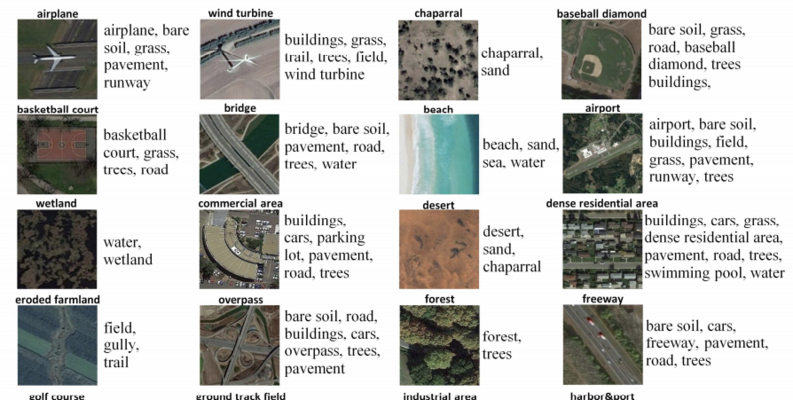

This notebook trains the google vision transformer on the MLRS Net Dataset. We would evaluate the models on validation dataset as well as the test dataset. I am going to use hugging face library to load dataset and train transformer. The results are at last cell.

Just fork the notebook and play with different Deep CNNs, transformers.

Multi label image classification assigns multiple labels to an image.

This notebook illustrates how to:

1. Fine-tune google/vit-large-patch16-224-in21k on the MLRS Net dataset to classify a image into multiple labels.
2. Generate predictions on test dataset.

Before we begin, make sure you have all the necessary 
libraries installed:

In [1]:
!pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 937.0 kB/s eta 0:00:00


In [2]:
# Get information about the accelerators
import torch
import warnings
warnings.filterwarnings('ignore')
if torch.cuda.is_available():
    print("CUDA is available.")
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"\nGPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i)} bytes")
        print(f"Memory Cached: {torch.cuda.memory_reserved(i)} bytes")
else:
    print("CUDA is not available.")

CUDA is available.
Number of GPUs: 2

GPU 0: Tesla T4
Memory Allocated: 0 bytes
Memory Cached: 0 bytes

GPU 1: Tesla T4
Memory Allocated: 0 bytes
Memory Cached: 0 bytes


# Loading MLRS Net Dataset

In [3]:
# Start by loading MLRS Net dataset from the 🤗 Datasets library.
from datasets import load_dataset
mlrs_net = load_dataset("vigneshwar472/MLRS-Net-for-modelling")

Generating train split:   0%|          | 0/65489 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21830 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/21842 [00:00<?, ? examples/s]

In [4]:
mlrs_net

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 65489
    })
    validation: Dataset({
        features: ['image', 'labels'],
        num_rows: 21830
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 21842
    })
})

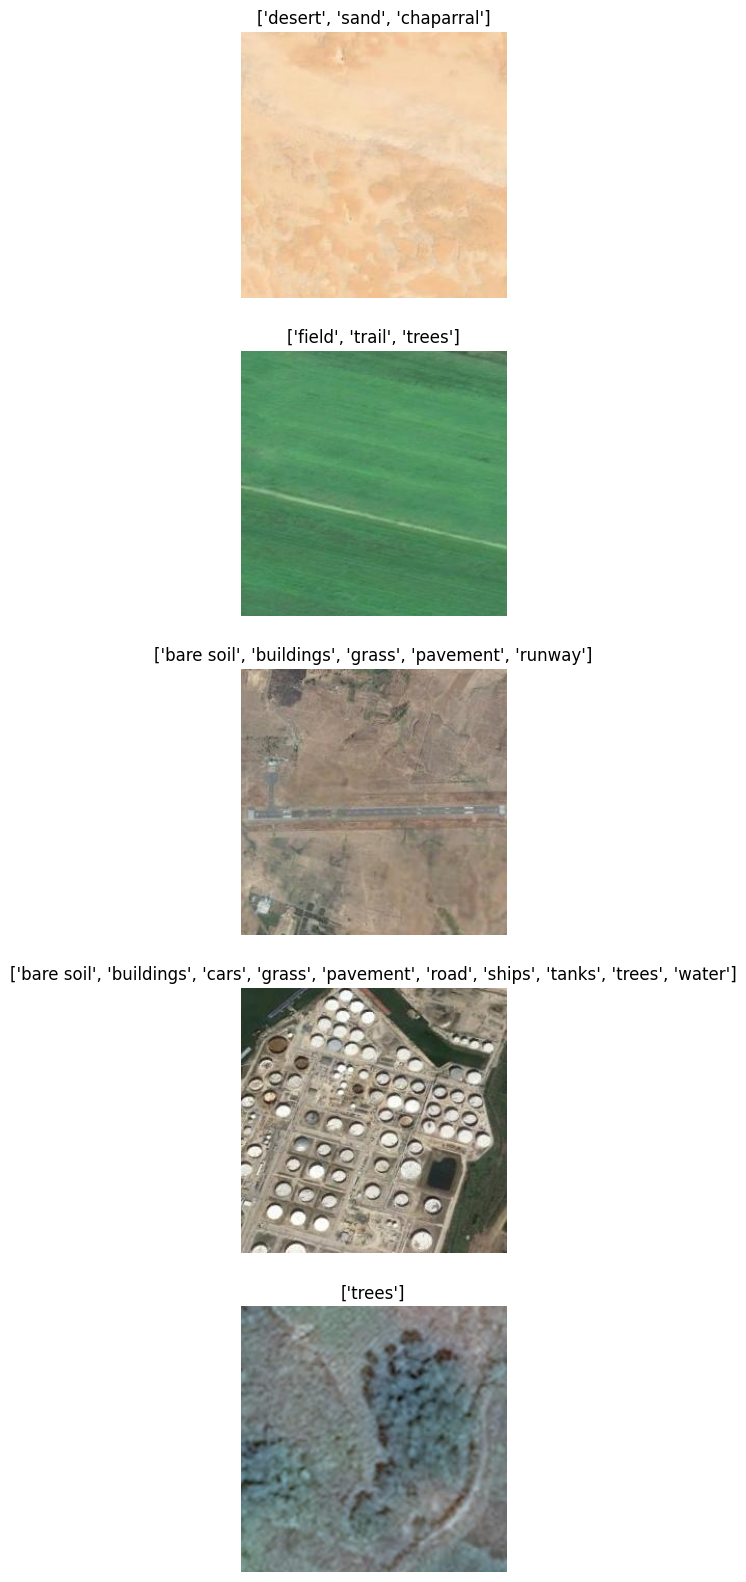

In [5]:
# See Some examples
import matplotlib.pyplot as plt
import numpy as np
def show_samples(ds,rows,cols):
    samples = ds.shuffle().select(np.arange(rows*cols)) # selecting random images
    fig = plt.figure(figsize=(cols*4,rows*4))
    # plotting
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['labels']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
            
show_samples(mlrs_net['train'],rows=5,cols=1)

For each example in dataset has two fields:
* image: a PIL image of the remote sensing image
* labels: the classes associated with it

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name to an integer and vice versa:

In [6]:
# These are the 60 classes to which the images were annotated.
labels = ['airplane', 'airport', 'bare soil', 'baseball diamond', 'basketball court',
          'beach', 'bridge', 'buildings', 'cars', 'chaparral', 'cloud', 'containers', 'crosswalk',
          'dense residential area', 'desert', 'dock', 'factory', 'field', 'football field',
          'forest', 'freeway', 'golf course', 'grass', 'greenhouse', 'gully', 'habor', 'intersection',
          'island', 'lake', 'mobile home', 'mountain', 'overpass', 'park', 'parking lot',
          'parkway', 'pavement', 'railway', 'railway station', 'river', 'road', 'roundabout',
          'runway', 'sand', 'sea', 'ships', 'snow', 'snowberg', 'sparse residential area', 'stadium',
          'swimming pool', 'tanks', 'tennis court', 'terrace', 'track', 'trail', 'transmission tower',
          'trees', 'water', 'wetland', 'wind turbine']
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

We ought to modify the labels column with a binary vector. Because as you can see that each image is associated with raw labels which makes it unsuitable for training purposes. 

In [7]:
for i in range(5):
    print(mlrs_net['train'][i]['labels'])

['bare soil', 'forest', 'trail', 'trees']
['buildings', 'cars', 'park', 'trail', 'trees', 'water']
['desert', 'sand']
['bare soil', 'buildings', 'cars', 'pavement', 'tennis court', 'trees']
['bare soil', 'transmission tower']


In [8]:
# We utilize the label2id dictionery and then make a one hot vector
# it is rather important that 1s and 0s are float values
def label_text_to_int(example):
    text_labels = example['labels']
    int_labels = [int(label2id[label]) for label in text_labels]
    ohv = [0. for _ in range(len(labels))]
    for i in int_labels:
        ohv[i] = 1.
    example['labels'] = ohv
    return example

mlrs_net = mlrs_net.map(label_text_to_int)

Map:   0%|          | 0/65489 [00:00<?, ? examples/s]

Map:   0%|          | 0/21830 [00:00<?, ? examples/s]

Map:   0%|          | 0/21842 [00:00<?, ? examples/s]

# Preprocess

The next step is to load a ViT image processor to process the image into a tensor:

In [9]:
from transformers import AutoImageProcessor
checkpoint = 'google/vit-large-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

2024-08-06 13:29:13.453553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 13:29:13.453664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 13:29:13.636148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


Apply some image transformations to the images to make the model more robust against overfitting. Here I’ll use torchvision’s transforms module.

Crop a random part of the image, resize it, and normalize it with the image mean and standard deviation:

In [10]:
from torchvision.transforms import Resize, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([Resize(size), ToTensor(), normalize])

Then create a preprocessing function to apply the transforms and return the pixel_values - the inputs to the model - of the image:

In [11]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

To apply the preprocessing function over the entire dataset, use 🤗 Datasets with_transform method. The transforms are applied on the fly when you load an element of the dataset:

In [12]:
mlrs_net = mlrs_net.with_transform(transforms)

Now create a batch of examples using DefaultDataCollator. Unlike other data collators in 🤗 Transformers, the DefaultDataCollator does not apply additional preprocessing such as padding.

In [13]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

**This is the most important part of the notebook. We should choose the metric correctly and correctly define compute_metrics function. Since this a multi label classification problem, the compute_metrics function must be modified. If you use the one which was mentioned in documentation then you will get an error while training.**
***
For this task, load the metrics:
1. accuracy
2. recall
3. precision
4. f1

I have loaded metrics seperately because recall, precision, f1 should be averaged by 'macro' parameter for multi label classification. But accuracy has nothing to do with 'macro' parameter.

In [14]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
metrics = evaluate.combine(["recall", "precision", "f1"])

In [15]:
import numpy as np
import torch

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sf = torch.nn.Softmax(dim=1)
    probabilities = sf(torch.from_numpy(logits))
    threshold = 0.6
    predictions = list()
    for array in probabilities:
        new_array = list()
        for p in array:
            if p >= threshold:
                new_array.append(1.)
            else:
                new_array.append(0.)
        predictions.append(new_array)
    predictions = np.array(predictions)
    for refs, preds in zip(labels, predictions):
        accuracy_metric.add_batch(references=refs, predictions=preds)
        metrics.add_batch(references=refs, predictions=preds)
    accuracy_dict = accuracy_metric.compute()
    metrics_dict = metrics.compute(average='macro')
    return {
        'accuracy' : accuracy_dict['accuracy'],
        'recall' : metrics_dict['recall'],
        'precision' : metrics_dict['precision'],
        'f1' : metrics_dict['f1']
    }

# Train

We’re ready to start training your model now! Load ViT with AutoModelForImageClassification. Specify the number of labels along with the number of expected labels, and the label mappings:

In [16]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    problem_type = "multi_label_classification",
    ignore_mismatched_sizes=True
)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


At this point, In the **train** part only three steps remain:

1. Define your training hyperparameters in TrainingArguments. It is important we don’t remove unused columns because that’ll drop the image column. Without the image column, we can’t create pixel_values. Set remove_unused_columns=False to prevent this behavior! The only other required parameter is output_dir which specifies where to save your model. At the end of each epoch, the Trainer will evaluate the accuracy and save the training checkpoint.
2. Pass the training arguments to Trainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.
3. Call train() to finetune your model

In [17]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['WANDB_DISABLED'] = 'true'

training_args = TrainingArguments(
    output_dir="/kaggle/working/mlrs_multi_label_classification_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=mlrs_net['train'],
    eval_dataset=mlrs_net['validation'],
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
0,0.081700,0.080407,0.918016,0.509230,0.954294,0.496731
1,0.053400,0.054836,0.919584,0.518764,0.953200,0.515181
2,0.043400,0.047895,0.919581,0.518659,0.955669,0.514975


TrainOutput(global_step=1533, training_loss=0.09858958548529041, metrics={'train_runtime': 14830.7017, 'train_samples_per_second': 13.247, 'train_steps_per_second': 0.103, 'total_flos': 5.375477679502772e+19, 'train_loss': 0.09858958548529041, 'epoch': 2.9956033219345386})

In [18]:
# Save the preprocessor and model to local directory
model.save_pretrained("/kaggle/working/MLRS_Net_google_VIT")
image_processor.save_pretrained("/kaggle/working/MLRS_Net_google_VIT")

['/kaggle/working/MLRS_Net_google_VIT/preprocessor_config.json']

# Predictions on test set

In [19]:
results = trainer.predict(mlrs_net['test'])

In [20]:
print("Results on test dataset are: ")
print('Accuracy = ', results.metrics['test_accuracy'])
print('Recall = ', results.metrics['test_recall'])
print('Precision = ', results.metrics['test_precision'])
print('F1 Score = ', results.metrics['test_f1'])

Results on test dataset are: 
Accuracy =  0.9195121020663554
Recall =  0.5188898246322001
Precision =  0.9542730146195484
F1 Score =  0.5153896633647791
